# Description

In [1]:
############# Libaries ###############

import h5py
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
import math
import time
import itertools
from itertools import product, zip_longest
import pickle
from tqdm import tqdm, trange
from datetime import date
import sklearn
from sklearn.cluster import KMeans

import sys
import os

In [2]:
subsection = False           #Looks at a region a sixteenth of the full size

In [3]:
brain_data = scipy.io.loadmat(os.getcwd() + '/MB_References/BLSA_1742_04_MCIAD_m41/NESMA_slice5.mat')
I_raw = brain_data['slice_oi']

if subsection:
    I_raw_x = I_raw.shape[0]//4
    I_raw_y = I_raw.shape[1]//4
    I_raw = I_raw[I_raw_x:2*I_raw_x, I_raw_y:2*I_raw_y, :]

n_vert, n_hori, n_elements_brain = I_raw.shape

t_increment_brain = 11.3 #This is a measurement originally indicated by Chuan Bi in the initial email about this data
tdata = np.linspace(t_increment_brain, (n_elements_brain)*(t_increment_brain), n_elements_brain)

# #This is how we will keep track of all voxels that are called --------------------------------- no iterator for voxels needed
# target_iterator = np.array([item for item in itertools.product(np.arange(0,n_vert,1), np.arange(0,n_hori,1))])

# all pixels with a lower mask amplitude are considered to be free water (i.e. vesicles)
mask_amplitude = 700


param_name_list_biX = [r'$c_1$',r'$c_2$',r'$T_{21}$',r'$T_{22}$']
param_name_list_moX = [r'$c_1$',r'$T_{21}$']

if subsection:
    vert1 = 37
    vert2 = 47
    hori1 = 25
    hori2 = 70
else:
    vert1 = 165             #60     #108
    vert2 = 180            #125     #116
    hori1 = 120            #100      #86
    hori2 = 180            #115      #93


    v_hi = n_vert//4*3
    v_lo = n_vert//4

    h_hi = n_hori//5*4
    h_lo = n_hori//5

vBox = (vert1,vert1,vert2,vert2,vert1)
hBox = (hori1,hori2,hori2,hori1,hori1)

noiseRegion = [vert1,vert2,hori1,hori2]


In [4]:
def G_off_biX(t, con_1, con_2, tau_1, tau_2, offSet): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2) + offSet
    return function

def G_off_moX(t, con_1, tau_1, offSet): 
    function = con_1*np.exp(-t/tau_1) + offSet
    return function

def G_biX(t, con_1, con_2, tau_1, tau_2): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
    return function

def G_moX(t, con_1, tau_1): 
    function = con_1*np.exp(-t/tau_1)
    return function

def J(t, con1, con2, tau1, tau2):
    func1 = np.exp(-t/tau1)
    func2 = np.exp(-t/tau2)
    func3 = (con1*t)*np.exp(-t/tau1)/(tau1**2)
    func4 = (con2*t)*np.exp(-t/tau2)/(tau2**2)
    jacobian = np.stack((func1, func2, func3, func4), axis=-1)
    
    return jacobian

In [5]:
def mask_data(raw, mask_amplitude):
    #Sets every decay curve in the data set where the amplitude is less than a threshold value to zero
    I_masked = np.copy(raw)
    I_masked[I_masked[:,:,0]<mask_amplitude] = 0
    return I_masked

def normalize_brain(I_data):
    n_vert, n_hori, n_elem = I_data.shape
    I_normalized = np.zeros(I_data.shape)
    for i_vert in range(n_hori):
        for i_hori in range(n_vert):
            data = I_data[i_vert,i_hori,:]
            if data[0]>0:
                data_normalized = data/(data[0])
            else:
                data_normalized = np.zeros(n_elements_brain)
            I_normalized[i_vert,i_hori,:] = data_normalized
    return I_normalized


def calculate_brain_SNR(raw, region):
    #calculates the SNR of the brain using a homogenous region fed into the 
    v1,v2,h1,h2 = region

    rawZone = raw[v1:v2,h1:h2,:]

    regionZero = rawZone[:, :, 0]
    regionZero_mean = np.mean(regionZero)

    regionEnd = rawZone[:, :, -3:] #last three points across the entire sampled region
    regionEnd_std = np.std(regionEnd)
    regionEnd_absMean = np.mean(np.abs(regionEnd))

    SNR_region = (regionZero_mean - regionEnd_absMean)/regionEnd_std

    return SNR_region

def calculate_indiv_SNR(sig, est_curve):
    residuals = sig - est_curve
    curve_std = np.max([np.std(residuals), 10**-16])
    return sig[0]/curve_std


In [6]:
def calculate_WSS(data,data_categories,centers):
    num_clusters = centers.shape[0]

    WSS = 0
    for i in range(num_clusters):
        category_mat = (data_categories==i)
        WSS += np.sum((data - centers[i])**2 * category_mat)

    return WSS

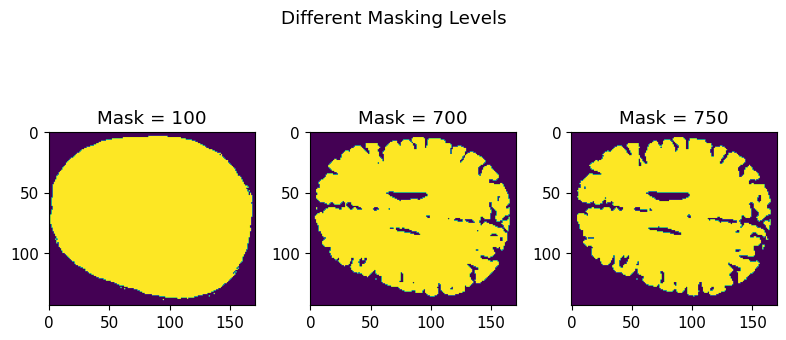

In [7]:
#### This ensures that the same mask is applied throughout

I_masked_100 = mask_data(I_raw, 100)
I_masked_700 = mask_data(I_raw, 700)
I_masked_750 = mask_data(I_raw, 750)

plt.rc('font', size  = 11)
fig, ax = plt.subplots(1,3, figsize = (8, 4), tight_layout=True)
fig.suptitle(f"Different Masking Levels")

ax[0].set_title("Mask = 100")
imc1 = ax[0].imshow(I_masked_100[v_lo:v_hi, h_lo:h_hi,0] != 0)

ax[1].set_title("Mask = 700")
imc1 = ax[1].imshow(I_masked_700[v_lo:v_hi, h_lo:h_hi,0] != 0)

ax[2].set_title("Mask = 750")
imc1 = ax[2].imshow(I_masked_750[v_lo:v_hi, h_lo:h_hi,0] != 0)


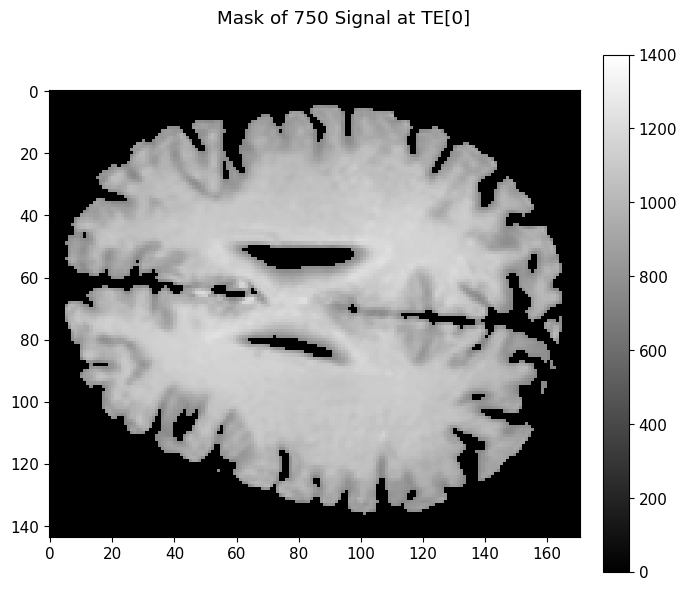

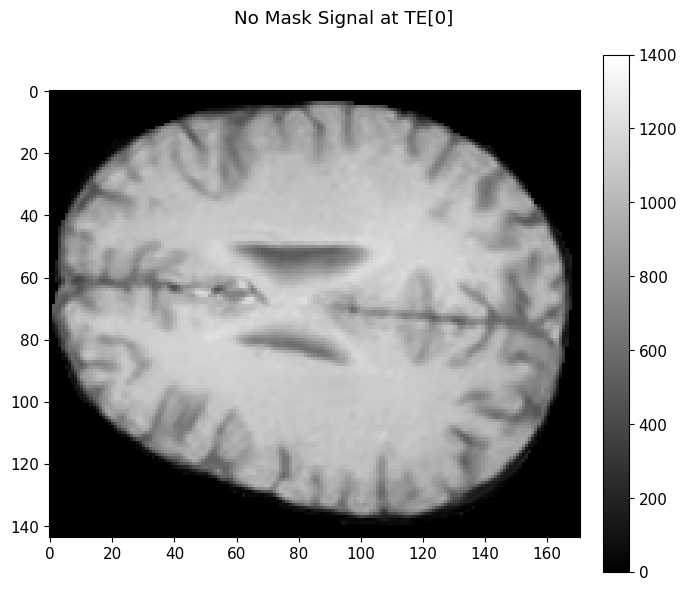

In [10]:
plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"Mask of 750 Signal at TE[0]")
imc1 = ax.imshow(I_masked_750[v_lo:v_hi, h_lo:h_hi,0], cmap = 'gray', vmin = 0, vmax = 1400)
fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"No Mask Signal at TE[0]")
imc1 = ax.imshow(I_raw[v_lo:v_hi, h_lo:h_hi,0], cmap = 'gray', vmin = 0, vmax = 1400)
fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

In [38]:
I_oi = I_masked_750

I_raw_linear = np.reshape(I_oi[:,:,0],(-1,1))

num_clusters = 3

kmeans = KMeans(n_clusters = num_clusters).fit(I_raw_linear)

kmeans_return = kmeans.labels_
assert(len(set(kmeans_return))==num_clusters)
kmeans_centers = np.array(kmeans.cluster_centers_)
assert(len(kmeans_centers)==num_clusters)
kmeans_rebuilt = np.reshape(kmeans_return,I_raw[:,:,0].shape)

rounded_centers = kmeans_centers.astype(int)
rounded_centers = np.reshape(rounded_centers,(1,-1))
rounded_centers.sort()
centers_List = ', '.join(str(x) for x in rounded_centers)


Text(0, 0.5, 'Within Cluster Square Sum (WSS)')

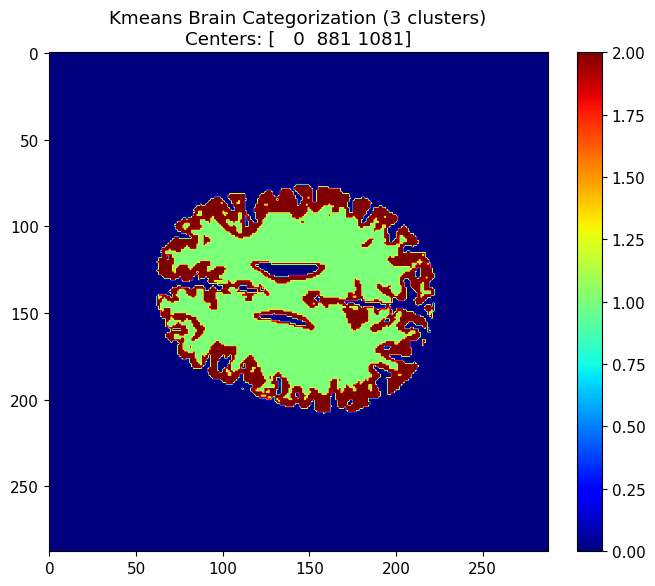

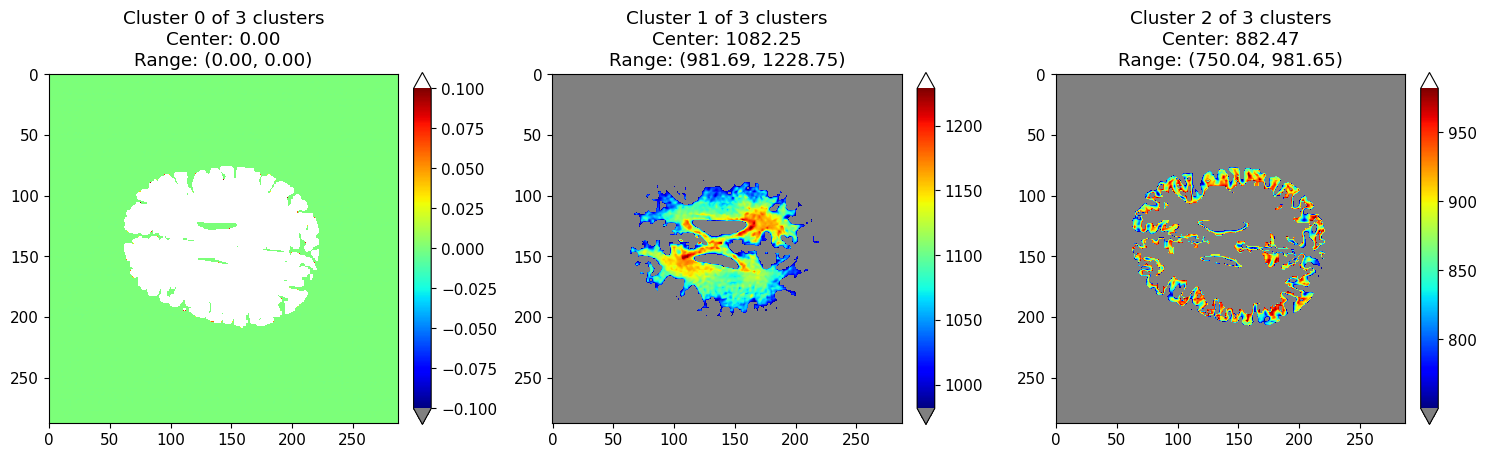

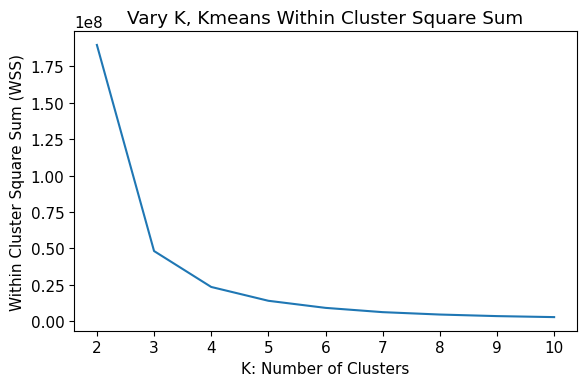

In [39]:
fig, ax = plt.subplots(figsize=(8,6),tight_layout=True)
imc1 = ax.imshow(kmeans_rebuilt, cmap = 'jet')
ax.set_title("Kmeans Brain Categorization (" + str(num_clusters)+ " clusters)" +
            "\nCenters: "+ centers_List)
fig.colorbar(imc1, fraction=0.046, pad=0.04)

fig, ax = plt.subplots(1,num_clusters,figsize=(15,6),tight_layout=True)
for k in range(num_clusters):
    cmap = plt.get_cmap('jet').copy()
    cmap.set_extremes(under='gray', over='white')
    if np.min(I_raw_linear[kmeans_return==k]) == 0:
        imc1 = ax[k].imshow(I_oi[:,:,0]*(kmeans_rebuilt==k) + 100*(kmeans_rebuilt!=k), cmap = cmap, vmin = np.min(I_raw_linear[kmeans_return==k]), vmax = np.max(I_raw_linear[kmeans_return==k]))
    else:
        imc1 = ax[k].imshow(I_oi[:,:,0]*(kmeans_rebuilt==k), cmap = cmap, vmin = np.min(I_raw_linear[kmeans_return==k]), vmax = np.max(I_raw_linear[kmeans_return==k]))
    ax[k].set_title("Cluster " + str(k) + " of " + str(num_clusters)+ " clusters" +
            "\nCenter: {:.2f}".format(np.mean(I_raw_linear[kmeans_return==k])) +
            "\nRange: ({:.2f}, {:.2f})".format(np.min(I_raw_linear[kmeans_return==k]),np.max(I_raw_linear[kmeans_return==k])))
    fig.colorbar(imc1, ax=ax[k], fraction=0.046, pad=0.04, extend = "both")


optK_WSS = np.zeros((9,1))
for i in range(0,9):
    kmeans = KMeans(n_clusters = i+2).fit(I_raw_linear)

    kmeans_return = kmeans.labels_
    kmeans_centers = kmeans.cluster_centers_
    kmeans_rebuilt = np.reshape(kmeans_return,I_raw[:,:,0].shape)

    optK_WSS[i] = calculate_WSS(I_oi[:,:,0],kmeans_rebuilt,kmeans_centers)

fig, ax = plt.subplots(figsize=(6,4),tight_layout=True)
ax.plot(np.arange(2,11,1),optK_WSS)
ax.set_title("Vary K, Kmeans Within Cluster Square Sum")
ax.set_xlabel("K: Number of Clusters")
ax.set_ylabel("Within Cluster Square Sum (WSS)")
